# 1. Load Data

In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the "../input/" directory.
import os
import matplotlib.pyplot as plt#visualization
from PIL import  Image
%matplotlib inline
import pandas as pd
import seaborn as sns#visualization
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization

In [2]:
telcom = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
telcom.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
#Data Manipulation

#Replacing spaces with null values in total charges column
telcom['TotalCharges'] = telcom["TotalCharges"].replace(" ",np.nan)

#Dropping null values from total charges column which contain .15% missing data 
telcom = telcom[telcom["TotalCharges"].notnull()]
telcom = telcom.reset_index()[telcom.columns]

#convert to float type
telcom["TotalCharges"] = telcom["TotalCharges"].astype(float)

# 2. Data Processing

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#customer id col
Id_col     = ['customerID']
#Target columns
target_col = ["Churn"]
#categorical columns
cat_cols   = telcom.nunique()[telcom.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
#numerical columns
num_cols   = [x for x in telcom.columns if x not in cat_cols + target_col + Id_col]
#Binary columns with 2 values
bin_cols   = telcom.nunique()[telcom.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    telcom[i] = le.fit_transform(telcom[i])
    
#Duplicating columns for multi value columns
telcom = pd.get_dummies(data = telcom,columns = multi_cols )

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(telcom[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_telcom_og = telcom.copy()
telcom = telcom.drop(columns = num_cols,axis = 1)
telcom = telcom.merge(scaled,left_index=True,right_index=True,how = "left")

# 3. Model Building

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.metrics import precision_score,recall_score
from yellowbrick.classifier import DiscriminationThreshold
#splitting train and test data 
train,test = train_test_split(telcom,test_size = .25 ,random_state = 111)
    
##seperating dependent and independent variables
cols    = [i for i in telcom.columns if i not in Id_col + target_col]
train_X = train[cols]
train_Y = train[target_col]
test_X  = test[cols]
test_Y  = test[target_col]

## 3.1 Base Model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1268
           1       0.68      0.54      0.60       490

   micro avg       0.80      0.80      0.80      1758
   macro avg       0.76      0.72      0.73      1758
weighted avg       0.79      0.80      0.79      1758

Accuracy   Score :  0.800910125142207
Area under curve :  0.720491856048413 



C:\Users\shuaix\anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



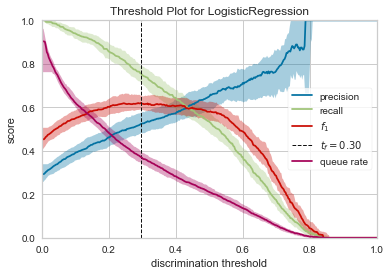

In [9]:
#threshold_plot - if True returns threshold plot for model
    
def telecom_churn_prediction(algorithm,training_x,testing_x,
                             training_y,testing_y,cols,cf,threshold_plot) :
    
    #model
    algorithm.fit(training_x,training_y)
    predictions   = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
    #coeffs
    if   cf == "coefficients" :
        coefficients  = pd.DataFrame(algorithm.coef_.ravel())
    elif cf == "features" :
        coefficients  = pd.DataFrame(algorithm.feature_importances_)
        
    column_df     = pd.DataFrame(cols)
    coef_sumry    = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
    
    print (algorithm)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy   Score : ",accuracy_score(testing_y,predictions))
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,predictions) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities[:,1])
    
    #plot confusion matrix
    trace1 = go.Heatmap(z = conf_matrix ,
                        x = ["Not churn","Churn"],
                        y = ["Not churn","Churn"],
                        showscale  = False,colorscale = "Picnic",
                        name = "matrix")
    
    #plot roc curve
    trace2 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2))
    trace3 = go.Scatter(x = [0,1],y=[0,1],
                        line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                        dash = 'dot'))
    
    #plot coeffs
    trace4 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Picnic",
                                  line = dict(width = .6,color = "black")))
    
    #subplots
    fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                            subplot_titles=('Confusion Matrix',
                                            'Receiver operating characteristic',
                                            'Feature Importances'))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,1,2)
    fig.append_trace(trace4,2,1)
    
    fig['layout'].update(showlegend=False, title="Model performance" ,
                         autosize = False,height = 900,width = 800,
                         plot_bgcolor = 'rgba(240,240,240, 0.95)',
                         paper_bgcolor = 'rgba(240,240,240, 0.95)',
                         margin = dict(b = 195))
    fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis3"].update(dict(showgrid = True,tickfont = dict(size = 10),
                                        tickangle = 90))
    py.iplot(fig)
    
    if threshold_plot == True : 
        visualizer = DiscriminationThreshold(algorithm)
        visualizer.fit(training_x,training_y)
        visualizer.poof()
        
logit  = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

telecom_churn_prediction(logit,train_X,test_X,train_Y,test_Y,
                         cols,"coefficients",threshold_plot = True)


## 3.2 Synthetic Minority Oversampling TEchnique (SMOTE)

SMOTE first selects a minority class instance a at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b.

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.90      0.75      0.82      1268
           1       0.55      0.79      0.65       490

   micro avg       0.76      0.76      0.76      1758
   macro avg       0.73      0.77      0.74      1758
weighted avg       0.81      0.76      0.77      1758

Accuracy   Score :  0.7633674630261661
Area under curve :  0.7727274190433271 



C:\Users\shuaix\anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



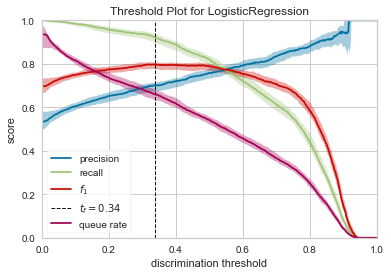

In [12]:
from imblearn.over_sampling import SMOTE

cols    = [i for i in telcom.columns if i not in Id_col+target_col]

smote_X = telcom[cols]
smote_Y = telcom[target_col]

#Split train and test data
smote_train_X,smote_test_X,smote_train_Y,smote_test_Y = train_test_split(smote_X,smote_Y,
                                                                         test_size = .25 ,
                                                                         random_state = 111)

#oversampling minority class using smote
os = SMOTE(random_state = 0)
os_smote_X,os_smote_Y = os.fit_sample(smote_train_X,smote_train_Y)
os_smote_X = pd.DataFrame(data = os_smote_X,columns=cols)
os_smote_Y = pd.DataFrame(data = os_smote_Y,columns=target_col)
###



logit_smote = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

telecom_churn_prediction(logit_smote,os_smote_X,test_X,os_smote_Y,test_Y,
                         cols,"coefficients",threshold_plot = True)


## 3.3 Recursive Feature Elimination

Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.91      0.74      0.81      1268
           1       0.54      0.80      0.65       490

   micro avg       0.76      0.76      0.76      1758
   macro avg       0.72      0.77      0.73      1758
weighted avg       0.80      0.76      0.77      1758

Accuracy   Score :  0.7559726962457338
Area under curve :  0.7701055816648428 



C:\Users\shuaix\anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



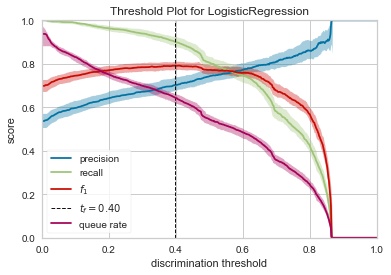

In [13]:
from sklearn.feature_selection import RFE

logit = LogisticRegression()

rfe = RFE(logit,10)
rfe = rfe.fit(os_smote_X,os_smote_Y.values.ravel())

rfe.support_
rfe.ranking_

#identified columns Recursive Feature Elimination
idc_rfe = pd.DataFrame({"rfe_support" :rfe.support_,
                       "columns" : [i for i in telcom.columns if i not in Id_col + target_col],
                       "ranking" : rfe.ranking_,
                      })
cols = idc_rfe[idc_rfe["rfe_support"] == True]["columns"].tolist()


#separating train and test data
train_rf_X = os_smote_X[cols]
train_rf_Y = os_smote_Y
test_rf_X  = test[cols]
test_rf_Y  = test[target_col]

logit_rfe = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
#applying model
telecom_churn_prediction(logit_rfe,train_rf_X,test_rf_X,train_rf_Y,test_rf_Y,
                         cols,"coefficients",threshold_plot = True)

tab_rk = ff.create_table(idc_rfe)
py.iplot(tab_rk)

## 3.4 Univariate Selection

* Feature Extraction with Univariate Statistical Tests (Chi-squared for classification)
* uses the chi squared (chi^2) statistical test for non-negative features to select the best features

In [14]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

#select columns
cols = [i for i in telcom.columns if i not in Id_col + target_col ]

#dataframe with non negative values
df_x = df_telcom_og[cols]
df_y = df_telcom_og[target_col]

#fit model with k= 3
select = SelectKBest(score_func = chi2,k = 3)
fit    = select.fit(df_x,df_y)

#Summerize scores
print ("scores")
print (fit.scores_)
print ("P - Values")
print (fit.pvalues_)

#create dataframe
score = pd.DataFrame({"features":cols,"scores":fit.scores_,"p_values":fit.pvalues_ })
score = score.sort_values(by = "scores" ,ascending =False)


#createing new label for categorical and numerical columns
score["feature_type"] = np.where(score["features"].isin(num_cols),"Numerical","Categorical")

#plot
trace  = go.Scatter(x = score[score["feature_type"] == "Categorical"]["features"],
                    y = score[score["feature_type"] == "Categorical"]["scores"],
                    name = "Categorial",mode = "lines+markers",
                    marker = dict(color = "red",
                                  line = dict(width =1))
                   )

trace1 = go.Bar(x = score[score["feature_type"] == "Numerical"]["features"],
                y = score[score["feature_type"] == "Numerical"]["scores"],name = "Numerical",
                marker = dict(color = "royalblue",
                              line = dict(width =1)),
                xaxis = "x2",yaxis = "y2"
               )
layout = go.Layout(dict(title = "Scores for Categorical & Numerical features",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     tickfont = dict(size =10),
                                     domain=[0, 0.7],
                                     tickangle = 90,zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "scores",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(b=200),
                        xaxis2=dict(domain=[0.8, 1],tickangle = 90,
                                    gridcolor = 'rgb(255, 255, 255)'),
                        yaxis2=dict(anchor='x2',gridcolor = 'rgb(255, 255, 255)')
                        )
                  )

data=[trace,trace1]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

scores
[2.54297062e-01 1.33482766e+02 8.18577694e+01 1.31271509e+02
 9.29483891e-02 1.04979224e+02 3.88864216e+00 8.68247305e-01
 6.51465136e+00 7.11376111e+01 3.72082851e+02 2.85475152e+02
 4.14036636e+02 2.85475152e+02 1.47165601e+02 2.82490201e+02
 2.85475152e+02 3.12098318e+01 2.50189168e+02 2.85475152e+02
 2.02160070e+01 4.04010811e+02 2.85475152e+02 1.35439602e+02
 6.96607349e+01 2.85475152e+02 1.73206148e+01 7.28626683e+01
 2.85475152e+02 1.59306111e+01 5.16714004e+02 1.76608724e+02
 4.86223101e+02 7.66190658e+01 9.99725387e+01 4.24113152e+02
 4.47251434e+01 1.63773281e+04 3.65307468e+03 6.29630810e+05]
P - Values
[6.14065505e-001 7.08954608e-031 1.46240915e-019 2.15953960e-030
 7.60461827e-001 1.23423173e-024 4.86137123e-002 3.51440986e-001
 1.06989295e-002 3.33158163e-017 6.58713045e-083 4.81399951e-064
 4.84690970e-092 4.81399951e-064 7.21988253e-034 2.15251740e-063
 4.81399951e-064 2.31590182e-008 2.36156214e-056 4.81399951e-064
 6.91717063e-006 7.37636434e-090 4.81399951e-0

## 3.5 KNN Classifier

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

 Classification report : 
               precision    recall  f1-score   support

           0       0.87      0.70      0.78      1268
           1       0.48      0.73      0.58       490

   micro avg       0.71      0.71      0.71      1758
   macro avg       0.68      0.71      0.68      1758
weighted avg       0.76      0.71      0.72      1758

Accuracy Score   :  0.7070534698521047
Area under curve :  0.7130287130625121


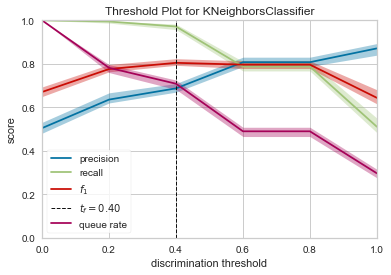

In [15]:
def telecom_churn_prediction_alg(algorithm,training_x,testing_x,
                                 training_y,testing_y,threshold_plot = True) :
    
    #model
    algorithm.fit(training_x,training_y)
    predictions   = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
    
    print (algorithm)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy Score   : ",accuracy_score(testing_y,predictions))
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,predictions) 
    print ("Area under curve : ",model_roc_auc)
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities[:,1])
     
    #plot roc curve
    trace1 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2),
                       )
    trace2 = go.Scatter(x = [0,1],y=[0,1],
                        line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                        dash = 'dot'))
    
    #plot confusion matrix
    trace3 = go.Heatmap(z = conf_matrix ,x = ["Not churn","Churn"],
                        y = ["Not churn","Churn"],
                        showscale  = False,colorscale = "Blues",name = "matrix",
                        xaxis = "x2",yaxis = "y2"
                       )
    
    layout = go.Layout(dict(title="Model performance" ,
                            autosize = False,height = 500,width = 800,
                            showlegend = False,
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(title = "false positive rate",
                                         gridcolor = 'rgb(255, 255, 255)',
                                         domain=[0, 0.6],
                                         ticklen=5,gridwidth=2),
                            yaxis = dict(title = "true positive rate",
                                         gridcolor = 'rgb(255, 255, 255)',
                                         zerolinewidth=1,
                                         ticklen=5,gridwidth=2),
                            margin = dict(b=200),
                            xaxis2=dict(domain=[0.7, 1],tickangle = 90,
                                        gridcolor = 'rgb(255, 255, 255)'),
                            yaxis2=dict(anchor='x2',gridcolor = 'rgb(255, 255, 255)')
                           )
                  )
    data = [trace1,trace2,trace3]
    fig = go.Figure(data=data,layout=layout)
    
    py.iplot(fig)
    
    if threshold_plot == True : 
        visualizer = DiscriminationThreshold(algorithm)
        visualizer.fit(training_x,training_y)
        visualizer.poof()

    
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
telecom_churn_prediction_alg(knn,os_smote_X,test_X,
                             os_smote_Y,test_Y,threshold_plot = True)

## 3.6 Gaussian Naive Bayes

GaussianNB(priors=None, var_smoothing=1e-09)

 Classification report : 
               precision    recall  f1-score   support

           0       0.92      0.67      0.77      1268
           1       0.49      0.84      0.62       490

   micro avg       0.72      0.72      0.72      1758
   macro avg       0.70      0.75      0.70      1758
weighted avg       0.80      0.72      0.73      1758

Accuracy Score   :  0.7150170648464164
Area under curve :  0.7542361424064895


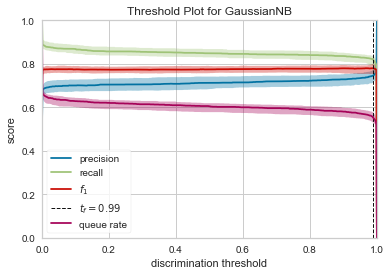

In [16]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB(priors=None)

telecom_churn_prediction_alg(gnb,os_smote_X,test_X,os_smote_Y,test_Y)

## 3.7 Support Vector Machine Classifier

In [17]:
from sklearn.svm import SVC

#Support vector classifier
#using linear hyper plane
svc_lin  = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
               decision_function_shape='ovr', degree=3, gamma=1.0, kernel='linear',
               max_iter=-1, probability=True, random_state=None, shrinking=True,
               tol=0.001, verbose=False)

cols = [i for i in telcom.columns if i not in Id_col + target_col]
telecom_churn_prediction(svc_lin,os_smote_X,test_X,os_smote_Y,test_Y,
                         cols,"coefficients",threshold_plot = False)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1.0, kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.90      0.73      0.81      1268
           1       0.53      0.80      0.64       490

   micro avg       0.75      0.75      0.75      1758
   macro avg       0.72      0.77      0.72      1758
weighted avg       0.80      0.75      0.76      1758

Accuracy   Score :  0.7491467576791809
Area under curve :  0.7653737204661045 



C:\Users\shuaix\anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



## 3.8 LightGBM Classifier

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.5, max_depth=7,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=500, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

 Classification report : 
               precision    recall  f1-score   support

           0       0.83      0.85      0.84      1268
           1       0.59      0.53      0.56       490

   micro avg       0.77      0.77      0.77      1758
   macro avg       0.71      0.69      0.70      1758
weighted avg       0.76      0.77      0.76      1758

Accuracy   Score :  0.7650739476678043
Area under curve :  0.6943974119616301 



C:\Users\shuaix\anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



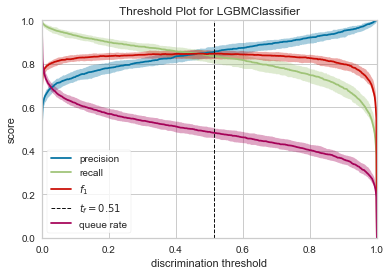

In [20]:
from lightgbm import LGBMClassifier

lgbm_c = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                        learning_rate=0.5, max_depth=7, min_child_samples=20,
                        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
                        n_jobs=-1, num_leaves=500, objective='binary', random_state=None,
                        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
                        subsample_for_bin=200000, subsample_freq=0)

cols = [i for i in telcom.columns if i not in Id_col + target_col]
telecom_churn_prediction(lgbm_c,os_smote_X,test_X,os_smote_Y,test_Y,
                         cols,"features",threshold_plot = True)


# 4. Model Performance

## 4.1 Metrics

In [22]:
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

#gives model report in dataframe
def model_report(model,training_x,testing_x,training_y,testing_y,name) :
    model.fit(training_x,training_y)
    predictions  = model.predict(testing_x)
    accuracy     = accuracy_score(testing_y,predictions)
    recallscore  = recall_score(testing_y,predictions)
    precision    = precision_score(testing_y,predictions)
    roc_auc      = roc_auc_score(testing_y,predictions)
    f1score      = f1_score(testing_y,predictions) 
    kappa_metric = cohen_kappa_score(testing_y,predictions)
    
    df = pd.DataFrame({"Model"           : [name],
                       "Accuracy_score"  : [accuracy],
                       "Recall_score"    : [recallscore],
                       "Precision"       : [precision],
                       "f1_score"        : [f1score],
                       "Area_under_curve": [roc_auc],
                       "Kappa_metric"    : [kappa_metric],
                      })
    return df

#outputs for every model
model1 = model_report(logit,train_X,test_X,train_Y,test_Y,
                      "Logistic Regression(Baseline_model)")
model2 = model_report(logit_smote,os_smote_X,test_X,os_smote_Y,test_Y,
                      "Logistic Regression(SMOTE)")
model3 = model_report(logit_rfe,train_rf_X,test_rf_X,train_rf_Y,test_rf_Y,
                      "Logistic Regression(RFE)")

model5 = model_report(knn,os_smote_X,test_X,os_smote_Y,test_Y,
                      "KNN Classifier")


model7 = model_report(gnb,os_smote_X,test_X,os_smote_Y,test_Y,
                      "Naive Bayes")
model8 = model_report(svc_lin,os_smote_X,test_X,os_smote_Y,test_Y,
                      "SVM Classifier Linear")
model10 = model_report(lgbm_c,os_smote_X,test_X,os_smote_Y,test_Y,
                      "LGBM Classifier")


#concat all models
model_performances = pd.concat([model1,model2,model3,
                                model5,
                                model7,model8,
                                model10],axis = 0).reset_index()

model_performances = model_performances.drop(columns = "index",axis =1)

table  = ff.create_table(np.round(model_performances,4))

py.iplot(table)

## 4.2 Compare Model Metrics

In [23]:
model_performances
def output_tracer(metric,color) :
    tracer = go.Bar(y = model_performances["Model"] ,
                    x = model_performances[metric],
                    orientation = "h",name = metric ,
                    marker = dict(line = dict(width =.7),
                                  color = color)
                   )
    return tracer

layout = go.Layout(dict(title = "Model performances",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "metric",
                                     zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(l = 250),
                        height = 780
                       )
                  )


trace1  = output_tracer("Accuracy_score","#6699FF")
trace2  = output_tracer('Recall_score',"red")
trace3  = output_tracer('Precision',"#33CC99")
trace4  = output_tracer('f1_score',"lightgrey")
trace5  = output_tracer('Kappa_metric',"#FFCC99")

data = [trace1,trace2,trace3,trace4,trace5]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)


## 4.3 Confusion Matrix

TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'

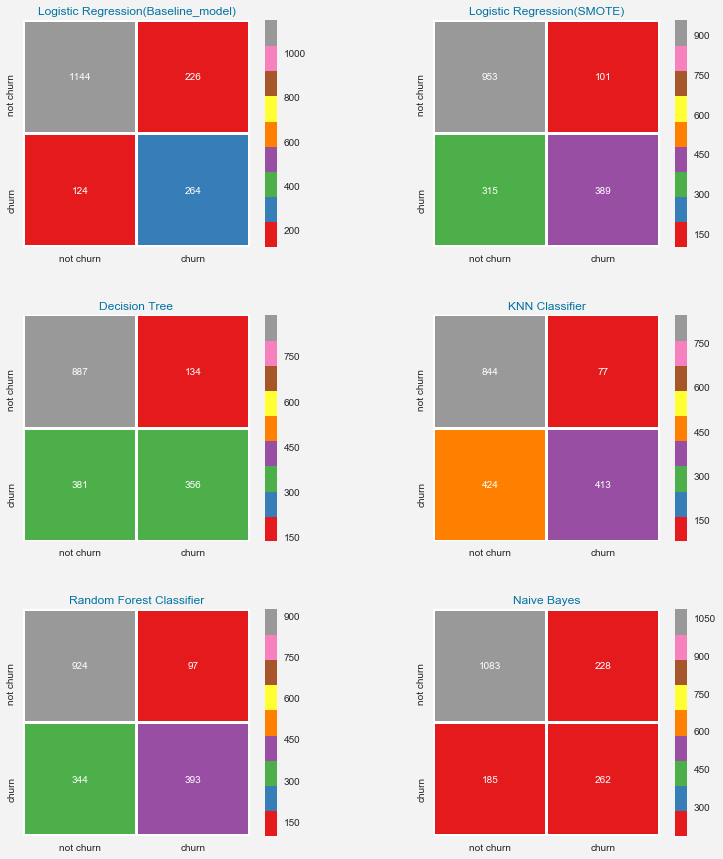

In [30]:
lst    = [logit,logit_smote,knn,
          gnb,svc_lin,lgbm_c]

length = len(lst)

mods   = ['Logistic Regression(Baseline_model)','Logistic Regression(SMOTE)',
          'Decision Tree','KNN Classifier','Random Forest Classifier',"Naive Bayes",
          'SVM Classifier Linear','SVM Classifier RBF', 'LGBM Classifier',
          'XGBoost Classifier']

fig = plt.figure(figsize=(13,15))
fig.set_facecolor("#F3F3F3")
for i,j,k in itertools.zip_longest(lst,range(length),mods) :
    plt.subplot(3,2,(j+1))
    predictions = i.predict(test_X)
    conf_matrix = confusion_matrix(predictions,test_Y)
    sns.heatmap(conf_matrix,annot=True,fmt = "d",square = True,
                xticklabels=["not churn","churn"],
                yticklabels=["not churn","churn"],
                linewidths = 2,linecolor = "w",cmap = "Set1")
    plt.title(k,color = "b")
    plt.subplots_adjust(wspace = .3,hspace = .3)